## Notebook for meta analysis of experiments to determine exclusions

In [1]:
%run ./rob_setup_notebook.ipynb

from ia_funcs import *


Suite2p path: ['/home/rlees/Documents/Code/suite2p/suite2p']
QNAP_path: /home/rlees/mnt/qnap 
QNAP_data_path /home/rlees/mnt/qnap/Data 
Pickle folder: /home/rlees/mnt/qnap/pkl_files 
Master pickle: /home/rlees/mnt/qnap/master_pkl/master_obj.pkl 
Figure save path: /home/rlees/mnt/qnap/Analysis/Plots 
STA movie save path: /home/rlees/mnt/qnap/Analysis/STA_movies 
S2 borders path: /home/rlees/mnt/qnap/Analysis/S2_borders


### Define list of pickled objects to meta analyse

In [2]:
pkl_list = [
            '2019-06-11_J048.pkl',
            '2019-06-13_J052.pkl',
            '2019-06-25_RL048.pkl',
            '2019-07-15_RL052.pkl',
            '2019-08-14_J058.pkl',
            '2019-08-14_J059.pkl',
            '2019-08-15_RL055.pkl',
            '2019-11-14_J061.pkl',
            '2019-11-14_J063.pkl',
            '2019-11-15_J064.pkl',
            '2019-11-18_J065.pkl',
            '2020-02-27_RL075.pkl',
            '2020-03-03_RL074.pkl',
            '2020-03-05_RL070.pkl',
            '2020-03-05_RL072.pkl',
            '2020-03-12_RL070.pkl',
            '2020-03-16_RL074.pkl',
            '2020-03-19_RL075.pkl',
#             '2020-03-20_RL080.pkl'
           ]

for i,pkl in enumerate(pkl_list):
    pkl_list[i] = os.path.join(qnap_path, 'pkl_files', pkl)

### Make STA movies

In [ ]:
staMovie(stam_save_path, pkl_list)

### Plot fluorescence across all concatenated t-series frames

Measuring mean cell fluorescence for: /home/rlees/mnt/qnap/pkl_files/2020-03-19_RL075.pkl               
Plotting mean cell fluorescence...


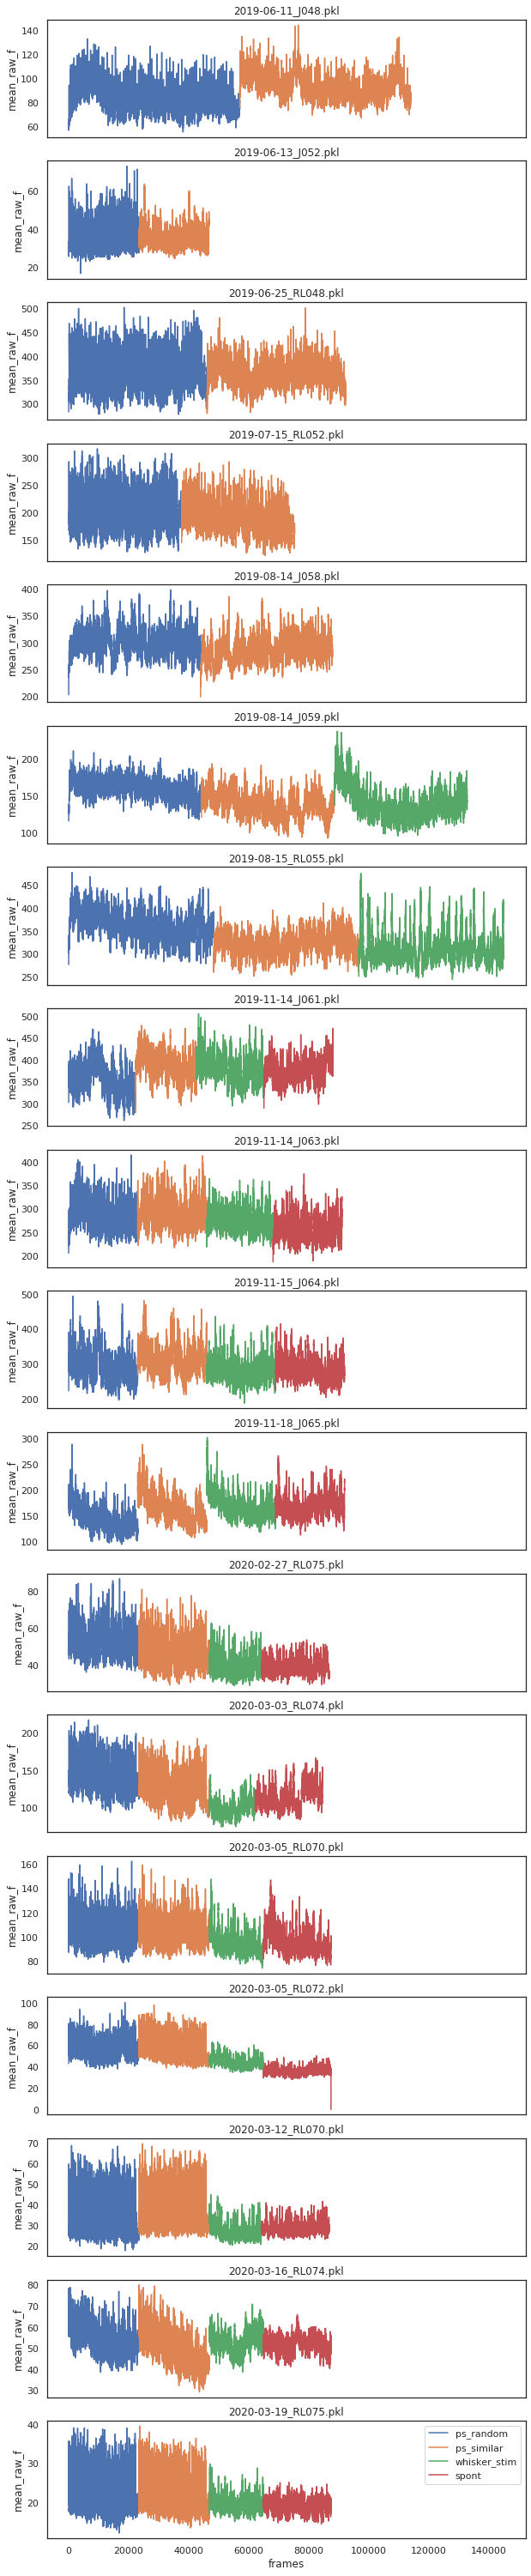

In [3]:
cellFluTime(pkl_list)
plt.savefig(os.path.join(fig_save_path, 'cell_fluorescence_time.svg'));

### Make downsampled stack of first 1000 and last 1000 frames of each experiment for all sessions

In [ ]:
save_path = os.path.join(qnap_path, 'Analysis', 'Drift_check', 'Raw')
downsampleTiff(pkl_list, save_path)

### Plot frame fluorescence over time for each experiment in all sessions

In [ ]:
data_folder = os.path.join(qnap_path, 'Analysis', 'Drift_check', 'Stacks')
frameFluTime(pkl_list, data_folder, legend=False)
plt.savefig(os.path.join(fig_save_path, 'frame_fluorescence_time.svg'));